In [55]:
import sys
import os
import glob
import random
import copy
from IPython.display import display, Markdown
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, value_assets, usd_price, lrna_price
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
# price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'USDA': {'usd price': 1, 'weight': 0.50},
    'USDB': {'usd price': 1, 'weight': 0.50}
}

assert sum([t['weight'] for t in assets.values()]) == 1

initial_tvl = 1000000

initial_state = GlobalState(
    pools={
        'stableswap': StableSwapPoolState(
            tokens={
                tkn: initial_tvl * assets[tkn]['weight'] for tkn in assets
            },
            amplification=100,
            trade_fee=0
        )
    },
    agents = {
        'Trader': Agent(
            holdings={tkn: 10000000000000 for tkn in assets}
        )
    },
    # external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # archive_all=False
)

In [56]:
amps = [12.5, 200, 40000]
amps = [100,200,300, 1000]
# trade_range = [2300000, 1900000, 1700000, 1500000, 1100000]
max_trade = 400000
steps = 100
amp_events = []
for i, amplification in enumerate(amps):
    initial_state.pools['stableswap'].amplification = amplification
    trade_size_min, trade_size_max = -max_trade, max_trade
    trade_sizes = [trade_size_min + i * (trade_size_max - trade_size_min) / steps for i in range(steps)]
    events = []
    

    for trade_size in trade_sizes:
        # trade to change the price of assets. 
        # We assume that whatever the resulting price is the new market price, and the trade is an arb trade.
        trade_state = copy.deepcopy(initial_state)
        events.append(
            run.run(trade_state, time_steps=1, silent=True)[-1].execute_swap(
                pool_id='stableswap',
                agent_id='Trader',
                tkn_sell='USDA' if trade_size > 0 else 'USDB',
                tkn_buy='USDB' if trade_size > 0 else 'USDA',
                sell_quantity=max(abs(trade_size), 0),
            )
        )

    amp_events.append(copy.deepcopy(events))
    
print('simulation finished.')

simulation finished.


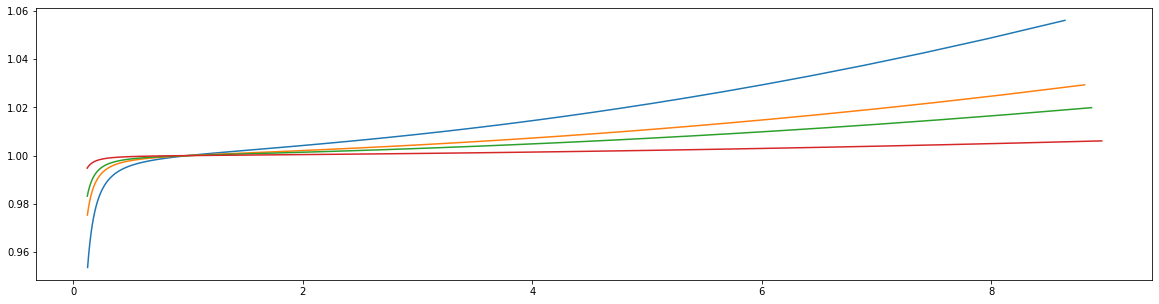

In [57]:
# colors = pu.color_gradient(len(amp_events), (255, 160, 0), (120, 0, 160))
reserve_ratios = []
usda_prices = []
for i, events in enumerate(amp_events):
            
    usda_prices.append([
        1 / event.pools['stableswap'].spot_price
        for event in events
    ])
    
    reserve_ratios.append([
        event.pools['stableswap'].liquidity['USDB'] / event.pools['stableswap'].liquidity['USDA']
        for event in events
    ])
    


# display(Markdown(f'<H3>Impermanent Loss Dynamics at {amps[i]} Amplification</H3>'))

# zoom in
plt.figure(figsize=(20,5))
# plt.title('impermanent loss as a function of depegged asset price (small change)')
# plt.xscale('log')
# plt.grid()
# plt.xticks(
#     [0.98, 0.99, 1, 1.01, 1.02],
#     ['$0.98', '$0.99', '$1.00', '$1.01', '$1.02']
# )
# plt.yticks(
#     [-0.001 * i for i in range(7)],
#     [f'-{round(0.1 * i * 10, 2) / 10}%' for i in range(7)]
# )

# for i, loss in enumerate(impermanent_loss):
#     center = usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - 1))[0])
#     range_width = abs(center - usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - 1.022))[0]))
#     start_range = center - range_width
#     end_range = center + range_width
#     plt.plot(usda_prices[i][start_range: end_range], loss[start_range: end_range], color=colors[i])
# plt.legend(amps, loc='center', title='amplification')

for i, ratio in enumerate(reserve_ratios):
    plt.plot(ratio, usda_prices[i])
    
# plt.plot(reserve_ratios[0], reserve_ratios[0])



plt.show()

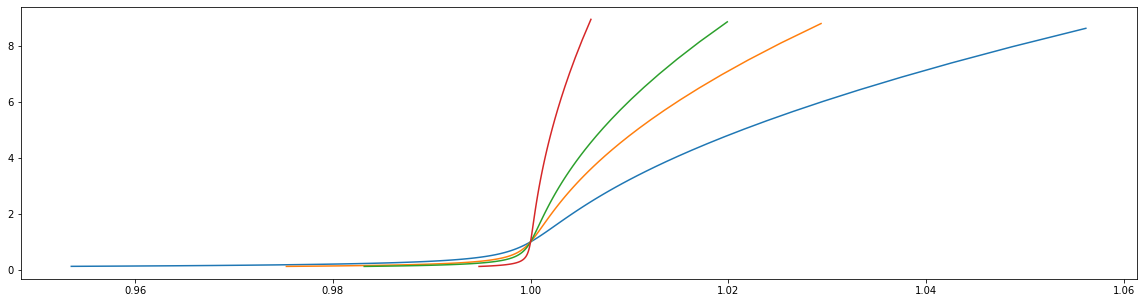

In [58]:
plt.figure(figsize=(20,5))

for i, ratio in enumerate(reserve_ratios):
    plt.plot( usda_prices[i], ratio)
    
# plt.plot(reserve_ratios[0], reserve_ratios[0])

plt.show()

In [59]:
print(usda_prices)

[[1.0561764705882355, 1.0487180347120812, 1.0425934138436381, 1.0375089727594735, 1.0332459072739975, 1.0296389432732733, 1.026561643521659, 1.0239161281040192, 1.0216257834282685, 1.0196300225103296, 1.017880472020439, 1.0163381645023097, 1.0149714474953038, 1.013754409978838, 1.012665686293179, 1.0116875384135597, 1.0108051455432059, 1.0100060495846088, 1.0092797188648803, 1.0086172023349205, 1.0080108535452508, 1.0074541088461613, 1.0069413080304839, 1.0064675484245251, 1.0060285655099237, 1.0056206347193053, 1.0052404902290832, 1.0048852574723202, 1.0045523967846637, 1.0042396561292515, 1.0039450312604425, 1.003666732009747, 1.0034031536315298, 1.0031528523469204, 1.0029145243838122, 1.0026869879380942, 1.0024691675832105, 1.0022600807372426, 1.002058825863014, 1.0018645721305266, 1.0016765503147689, 1.001494044737655, 1.0013163860920142, 1.001142945009424, 1.000973126253242, 1.0008063634341455, 1.0006421141585091, 1.0004798555304872, 1.000319079937082, 1.000159291052107, 1.0, 0.99

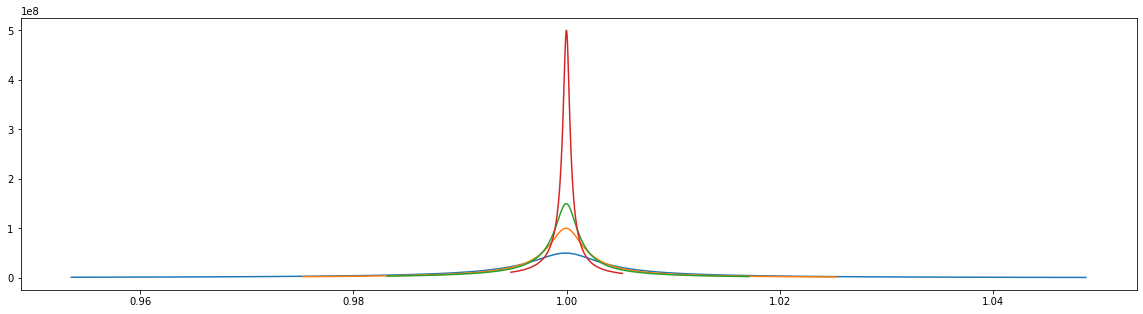

In [60]:
liq_depth_per_dollar = []
usda_prices2 = []

for i, events in enumerate(amp_events):
    prices = [1/event.pools['stableswap'].spot_price for event in events]
    liq_depth = [event.pools['stableswap'].liquidity['USDA'] for event in events]
    price_diffs = [prices[i] - prices[i-1] for i in range(1, len(prices))]
    liq_depth_per_dollar.append([(liq_depth[i]-liq_depth[i+1])/price_diffs[i] for i in range(len(price_diffs))])
    usda_prices2.append(prices[1:])
    
plt.figure(figsize=(20,5))

for i, y in enumerate(liq_depth_per_dollar):
    plt.plot(usda_prices2[i], y)
    
plt.show()